This notebook is broken bc of file names

In [2]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import plotly.express as px
from structure import scriptures_structure
import pandas as pd
import os

In [3]:
def get_label(index, indexes, text):
    text_indices = indexes[index]
    chunk = text[text_indices[0]:text_indices[1]]
    verse = text_indices[2]
    return chunk, verse

In [4]:
def generate_all_labels(index, indexes, text):
    labels = []
    for i in range(index):
        label, verse = get_label(i, indexes, text)
        labels.append(label)
    return labels


In [9]:
def generate_heatmap(source_1, source_2, w_1, w_2, i_1, i_2):
    path_1 = scriptures_structure.get_text_file_path(source_1)
    path_2 = scriptures_structure.get_text_file_path(source_2)

    with open(path_1) as f:
        text_1 = f.read()

    with open(path_2) as f:
        text_2 = f.read()

    embedding_path_1, index_path_1 = scriptures_structure.get_embedding_file_path(source_1+"/"+w_1+"/"+i_1)
    embedding_path_2, index_path_2 = scriptures_structure.get_embedding_file_path(source_2+"/"+w_2+"/"+i_2)

    print(embedding_path_1)
    
    data_1 = np.genfromtxt(embedding_path_1,delimiter=',')
    data_2 = np.genfromtxt(embedding_path_2,delimiter=',')

    indexes_1 = np.genfromtxt(index_path_1,delimiter=',', dtype=int)
    indexes_2 = np.genfromtxt(index_path_2,delimiter=',', dtype=int)

    cos_sim = dot(data_1, data_2.transpose())/(norm(data_1)*norm(data_2))
    print(cos_sim)
    
    length_1 = cos_sim.shape[0]
    length_2 = cos_sim.shape[1]
    labels_1 = generate_all_labels(length_1, indexes_1, text_1)
    labels_2 = generate_all_labels(length_2, indexes_2, text_2)
    im = px.imshow(cos_sim[:length_1, :length_2],
                x=labels_2, 
                y=labels_1,
                width=1500,
                height=1000,
                text_auto=False)

    im.update_xaxes(showticklabels=False)
    im.update_yaxes(showticklabels=False)

    im.show()

- Determine threshold - .000750

Mean transform on embedding data...

In [11]:
def mean_transform(path):
    df = pd.read_csv(path, header=None, index_col=None)
    df = df - df.mean()
    df.to_csv(path, index=False, header=False)

In [5]:
# Grab ten highest matches
def get_highest_matches(n_matches, cos_sim, threshold):
    threshold = 0.000745

    result_dict = {}

    num = 0
    for i in range(cos_sim.shape[0]):
        for j in range(cos_sim.shape[1]):
            cos_sim_val = cos_sim[i, j]
            if cos_sim_val >= threshold:
                num += 1
                line_1 = get_label(i, indexes_1, text_1)
                line_2 = get_label(j, indexes_2, text_2)

                # Save to dict
                result_dict[cos_sim_val] = (line_1, line_2)


    print('Number found: ', num)

    for key in sorted(result_dict):
        print('-----------------------------')
        print('Cosine Value: ', key)
        print('LINE 1: ', result_dict[key][0])
        print('~~~~~~~~~~~~~~~')
        print('LINE 2: ', result_dict[key][1])

In [12]:
# Get highest matches + heatmap for given sliding window size and width
def evaluate_data(source_1, source_2, w_1, w_2, i_1, i_2, threshold):
    path_1 = scriptures_structure.get_text_file_path(source_1)
    path_2 = scriptures_structure.get_text_file_path(source_2)

    with open(path_1) as f:
        text_1 = f.read()

    with open(path_2) as f:
        text_2 = f.read()

    embedding_path_1, index_path_1 = scriptures_structure.get_embedding_file_path(source_1+"/"+w_1+"/"+i_1)
    embedding_path_2, index_path_2 = scriptures_structure.get_embedding_file_path(source_2+"/"+w_2+"/"+i_2)
    
    data_1 = np.genfromtxt(embedding_path_1,delimiter=',')
    data_2 = np.genfromtxt(embedding_path_2,delimiter=',')

    indexes_1 = np.genfromtxt(index_path_1,delimiter=',', dtype=int)
    indexes_2 = np.genfromtxt(index_path_2,delimiter=',', dtype=int)

    cos_sim = dot(data_1, data_2.transpose())/(norm(data_1)*norm(data_2))

    print('cos sim: ', cos_sim)
    print('cos sim shape: ', cos_sim.shape)

    result_dict = {}

    num = 0
    for i in range(cos_sim.shape[0]):
        for j in range(cos_sim.shape[1]):
            cos_sim_val = cos_sim[i, j]
            if cos_sim_val >= threshold:
                num += 1
                line_1, verse_1 = get_label(i, indexes_1, text_1)
                line_2, verse_2 = get_label(j, indexes_2, text_2)

                # Save to dict
                result_dict[cos_sim_val] = (line_1, line_2, verse_1, verse_2)


    print('Number found: ', num)

    sorted_dict = sorted(result_dict, reverse=True)
    #for key in sorted(result_dict, reverse=True):
    for i in range(len(sorted_dict)):
        print('////////////////////////////////////////////////////////////////////////////')
        print('Cosine Value: ', sorted_dict[i])
        print('Source: ', source_1)
        print('Verse ', result_dict[sorted_dict[i]][2])
        print('LINE 1: ', result_dict[sorted_dict[i]][0])
        print('--------------------------------------------')
        print('Source: ', source_2)
        print('Verse ', result_dict[sorted_dict[i]][3])
        print('LINE 2: ', result_dict[sorted_dict[i]][1])

    length_1 = cos_sim.shape[0]
    length_2 = cos_sim.shape[1]
    labels_1 = generate_all_labels(length_1, indexes_1, text_1)
    labels_2 = generate_all_labels(length_2, indexes_2, text_2)

    im = px.imshow(cos_sim[:length_1, :length_2],
                x=labels_2, 
                y=labels_1,
                width=1500,
                height=1000,
                text_auto=False)

    im.update_xaxes(showticklabels=False)
    im.update_yaxes(showticklabels=False)

    im.show()

    plt.figure()
    plt.hist(cos_sim.flatten(), bins=50)


In [13]:
evaluate_data("alma/36", "alma/36", "40", "40", "10", "10",threshold=0.003)

FileNotFoundError: data/scriptures/book_of_mormon/embeddings/alma/036.w040.i010.embeddings.csv not found.

Number found:  359
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.02096111982809428
Source:  alma/36
Verse  5
LINE 1:  made these things known unto me, not of any worthiness of myself;
For I went about with the sons of Mosiah, seeking to destroy the church of God; but behold, God sent his holy angel to stop us by the
--------------------------------------------
Source:  alma/36
Verse  5
LINE 2:  made these things known unto me, not of any worthiness of myself;
For I went about with the sons of Mosiah, seeking to destroy the church of God; but behold, God sent his holy angel to stop us by the
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.019947856496289603
Source:  alma/36
Verse  28
LINE 1:  Egypt, and he has swallowed up the Egyptians in the Red Sea; and he led them by his power into the promised land; yea, and he has delivered them out of bondage and captivity from time to time.
Yea, and
---

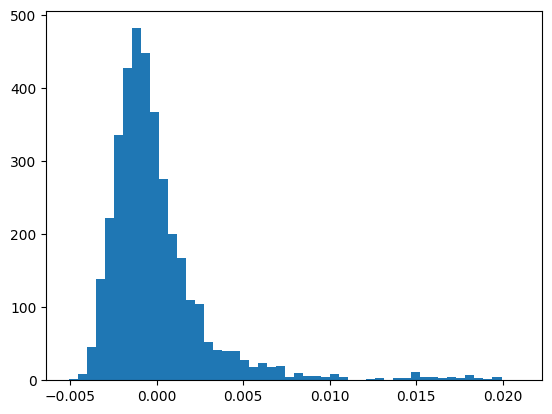

In [8]:
evaluate_data("alma/36", "alma/36", "40", "40", "20", "20", threshold=0.003)

Number found:  357
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.02096146143322275
Source:  alma/36
Verse  5
LINE 1:  made these things known unto me, not of any worthiness of myself;
For I went about with the sons of Mosiah, seeking to destroy the church of God; but behold, God sent his holy angel to stop us by the
--------------------------------------------
Source:  alma/36
Verse  5
LINE 2:  made these things known unto me, not of any worthiness of myself;
For I went about with the sons of Mosiah, seeking to destroy the church of God; but behold, God sent his holy angel to stop us by the
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.019955393744588285
Source:  alma/36
Verse  14
LINE 1:  my God did rack my soul with inexpressible horror.
Oh, thought I, that I could be banished and become extinct both soul and body, that I might not be brought to stand in the presence of my God, to be
-----

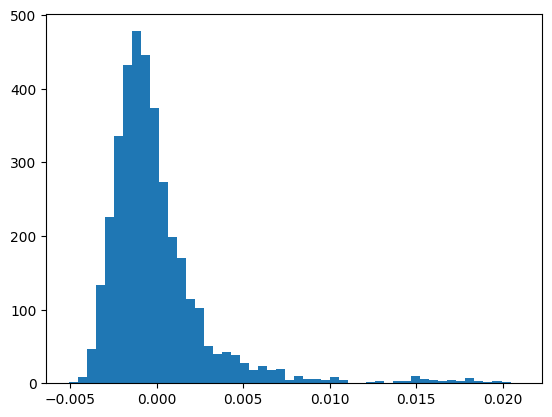

In [14]:
evaluate_data("alma/36", "alma/36", "40", "40", "20", "20", threshold=0.003)

In [14]:
folder_path = './data/scriptures/book_of_mormon/embeddings/ether/'
for filename in os.listdir(folder_path):
    if filename.endswith('embeddings.csv'):
        file_path = os.path.join(folder_path, filename)
        print(f"Processing {file_path}")
        mean_transform(file_path)

Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w007.i003.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w010.i003.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w010.i005.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w015.i003.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w015.i007.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w020.i005.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w020.i006.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w020.i010.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w030.i007.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w030.i015.embeddings.csv
Processing ./data/scriptures/book_of_mormon/embeddings/ether/012.w050.i012.embeddings.csv
Processing

notes:
- 7 - too small, not interesting, just word matching
- Larger widths give results that are more thematic, and highlight areas of the heatmap more specifically than being everywhere.
- The best way to reduce the blurriness is just n/2
- Best w seems to be between 30 and 50


In [14]:
evaluate_data("alma/32", "ether/12", "50", "50", "25", "25", threshold=0.004)

FileNotFoundError: data/scriptures/book_of_mormon/embeddings/alma/032.w050.i025.embeddings.csv not found.

cos sim:  [[ 3.12599867e-04 -1.25803382e-04 -4.18193992e-04 ... -8.41720661e-05
  -6.54040392e-04 -5.18035545e-04]
 [-1.92280458e-04  1.10688263e-04  9.12447651e-04 ... -3.05047425e-04
  -1.41228527e-03 -1.22704983e-03]
 [ 5.98428500e-05 -2.21679327e-04 -1.22876484e-03 ... -6.99773657e-04
  -1.22178371e-03 -3.99712328e-06]
 ...
 [ 3.02414959e-03  1.58146932e-03  2.06136486e-03 ...  1.82231427e-04
   5.64576421e-04 -5.41203913e-04]
 [ 1.08265462e-03 -9.36378312e-04  1.63444191e-03 ...  4.64871697e-04
   1.92192995e-04  3.22968460e-04]
 [-1.27008817e-03 -1.65128153e-03  9.69624529e-04 ...  1.34127135e-03
   5.02469968e-04  1.56902266e-03]]
cos sim shape:  (76, 96)
Number found:  8
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.00446905980638648
Source:  ether/12
Verse  36
LINE 1:  the Gentiles grace, that they might have charity.
And it came to pass that the Lord said unto me: If they have not charity it mattereth not unto thee, thou hast be

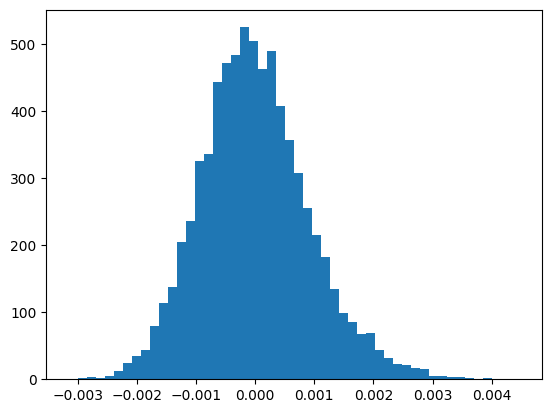

In [15]:
evaluate_data("ether/12", "moro/7", "40", "40", "20", "20", threshold=0.0035)

Normalize across all of the data?
Sometimes matches are weird, unexpected..